In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import os,sys
import random
from skimage.transform import resize
import models
sys.path.insert(0,'/home/huangz78/hydro/unet3d/')
import torch.fft as F
from models.unet3d_model import UNet3D,ResidualUNet3D 
from models.dnet import weights_init,Discriminator
from models.utils import *
from train import gan_train,noise_generate
from importlib import reload
from scipy.interpolate import griddata

from torch.autograd import Variable
import copy

manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Is denoising in the Fourier domain a good idea?

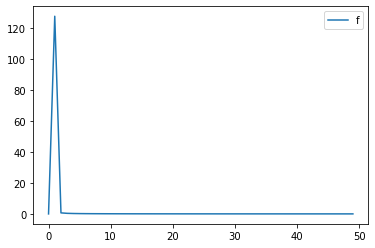

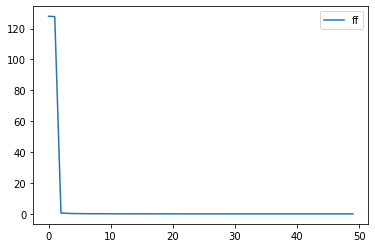

In [12]:
x  = torch.tensor(np.linspace(0,2*np.pi,256))
y  = torch.sin(x)
z  = torch.ones_like(x) * 0.5
yy = y + z

f  = F.fft(y)
ff = F.fft(yy)

plt.figure()
plt.plot(torch.abs(f[0:50]),label='f')
# plt.plot(torch.abs(ff),label='ff')
plt.legend(loc='best')
# plt.yscale('log')
plt.show()

plt.figure()
# plt.plot(torch.abs(f),label='f')
plt.plot(torch.abs(ff[0:50]),label='ff')
plt.legend(loc='best')
# plt.yscale('log')
plt.show()

In [10]:
reload(models.utils)
from models.utils import illustrate, visualization

In [3]:
errordata.files

['g_loss',
 'd_loss',
 'val_loss',
 'nrmse_train',
 'l1_train',
 'nrmse_val',
 'l1_val']

In [15]:
a = torch.randn((2,1,2,320,320))
b = torch.randn((320,320))
(a * b).shape

torch.Size([2, 1, 2, 320, 320])

# check conservation of mass

In [16]:
datapath = '/mnt/shared_b/data/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 41

batchsize = 5
fileexp_inds = [7736+i for i in range(batchsize)]

dyn   = torch.zeros((batchsize,1,dep,img_size,img_size))    # load one sample, show it
noise = torch.zeros((batchsize,1,dep,img_size,img_size))    # make a noise sample, add it to the ground truth, show it

for fileexp_ind in range(len(fileexp_inds)):
    filename = ncfiles[fileexp_inds[fileexp_ind]]
    sim = xr.open_dataarray(datapath+filename)
    # val.append(np.max(np.array(sim)[:dep,:,:].flatten()))
    sim.close()
    for t in range(dep):
        dyn[fileexp_ind,0,t,:,:] = torch.tensor( sim.isel(t=t)[:img_size,:img_size].values )

# dyn   = np.zeros((1,1,dep,256,256))    # load one sample, show it
# noise = np.zeros((1,1,dep,256,256))    # make a noise sample, add it to the ground truth, show it
# for t in range(dep):
#     dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)

Total amount of files: 13798


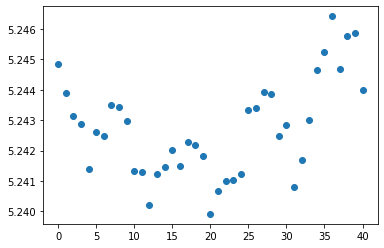

In [10]:
# check conservation of mass

mass = np.zeros(dep)
for ind in range(dep):
    img = dyn[0,0,ind,:,:]
    mass[ind] = integration_over_sphere(img)
plt.scatter(range(dep),mass)
plt.show()

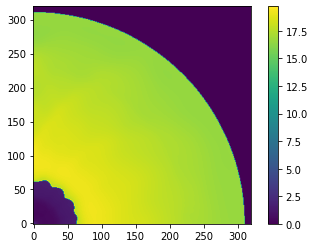

In [5]:
img = dyn[0,0,0,:,:]
plt.imshow(img,origin='lower')
plt.colorbar()
plt.show()

In [24]:
def compute_mass(imgs,Rrho=1,Rz=1):
    '''
    computing through cylindrical coordinate
    '''
    drho = Rrho / imgs.shape[3]
    dz   = Rz   / imgs.shape[4]
    metrics = torch.linspace(0,Rrho,imgs.shape[4]).repeat(imgs.shape[3],1)
    integrand = imgs * metrics
    mass = 2*np.pi * torch.sum(integrand,dim=(3,4)) * drho * dz 
    return torch.squeeze(mass)

In [25]:
compute_mass(dyn)

> <ipython-input-24-455078b5c62c>(6)compute_mass()
      4     '''
      5     breakpoint()
----> 6     drho = Rrho / imgs.shape[3]
      7     dz   = Rz   / imgs.shape[4]
      8 

ipdb> unt 11
> <ipython-input-24-455078b5c62c>(11)compute_mass()
      8 
      9     metrics = torch.linspace(0,Rrho,imgs.shape[4]).repeat(imgs.shape[3],1)
     10     integrand = imgs * metrics
---> 11     mass = 2*np.pi * torch.sum(integrand,dim=(3,4)) * drho * dz
     12     return torch.squeeze(mass)

ipdb> n
> <ipython-input-24-455078b5c62c>(12)compute_mass()
      8 
      9     metrics = torch.linspace(0,Rrho,imgs.shape[4]).repeat(imgs.shape[3],1)
     10     integrand = imgs * metrics
     11     mass = 2*np.pi * torch.sum(integrand,dim=(3,4)) * drho * dz
---> 12     return torch.squeeze(mass)

ipdb> p torch.squeeze(mass).shape
torch.Size([5, 41])
ipdb> q


BdbQuit: 

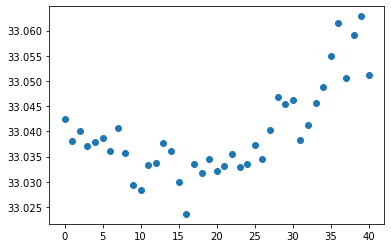

In [13]:
mass = np.zeros(dep)
for ind in range(dep):
    img = dyn[0,0,ind,:,:]
    mass[ind] = compute_mass(img)
plt.scatter(range(dep),mass)
plt.show()

In [ ]:
def compute_mass(rho, R, z):
    dR = R[1] - R[0]
    dz = z[1] - z[0]
    m = sum(2*np.pi*R[:]*rho[:])*dR*dz
    return m

In [44]:
grid_r, grid_theta = np.mgrid[0:1:301j, np.pi/2:np.pi:301j]

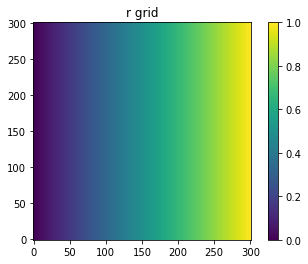

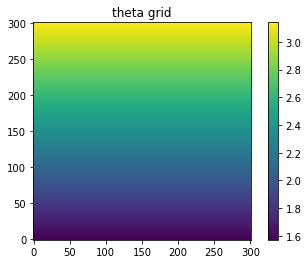

In [76]:
plt.imshow(grid_r.T,origin='lower')
plt.colorbar()
plt.title('r grid')
plt.show()

plt.imshow(grid_theta.T,origin='lower')
plt.colorbar()
plt.title('theta grid')
plt.show()

In [18]:
def integration_over_sphere(img,img_size=320,grid_len=300,method='cubic',R=1,Rx=1,Ry=1):
    
    grid_r, grid_theta = np.mgrid[0:R:301j, np.pi/2:np.pi:301j]
    dr = 1/grid_len
    dtheta = np.pi/(2*grid_len)
    Cartesian_grid = [[i/img_size*Rx,j/img_size*Ry] for i in range(img_size) for j in range(img_size)]
    radius = lambda x,y: np.sqrt(x**2 + y**2)
    theta  = lambda x,y: np.arctan(x/y) + np.pi/2
    
    Spherical_grid = []
    vals = []
    for point in Cartesian_grid:
        if point[0]==0:
            Spherical_grid.append([point[1],np.pi/2])
        elif (point[1]==0) and (point[0]!=0):
            Spherical_grid.append([point[0],np.pi])
        else:
            Spherical_grid.append([radius(point[0],point[1]),theta(point[0],point[1])])
        vals.append(img[int(point[0]*img_size/Rx),int(point[1]*img_size/Ry)])
        
    Spherical_grid = np.array(Spherical_grid)
#     Cartesian_grid = np.array(Cartesian_grid)
    vals = np.array(vals)

    den_interp = griddata(Spherical_grid, vals, (grid_r, grid_theta), method=method).T
    metric = (grid_r.T)**2 * np.sin(grid_theta.T)
    
    mass = np.sum(metric * np.nan_to_num(den_interp)) * dr * dtheta
    
    return mass

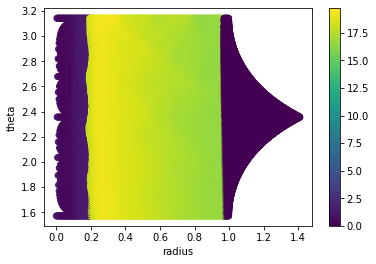

In [75]:
plt.scatter(Spherical_grid[:,0],Spherical_grid[:,1],c=vals)
plt.xlabel('radius')
plt.ylabel('theta')
plt.colorbar()
plt.show()

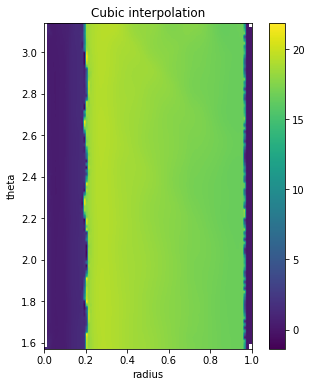

In [23]:
plt.imshow(den_interp.T, extent=(0,1,np.pi/2,np.pi), origin='lower')
plt.title('Cubic interpolation')
plt.gcf().set_size_inches(6, 6)
plt.colorbar()
plt.xlabel('radius')
plt.ylabel('theta')
plt.show()

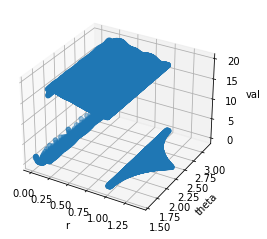

In [33]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Spherical_grid[:,0],Spherical_grid[:,1],vals)
ax.set_xlabel('r')
ax.set_ylabel('theta')
ax.set_zlabel('val')
plt.show()

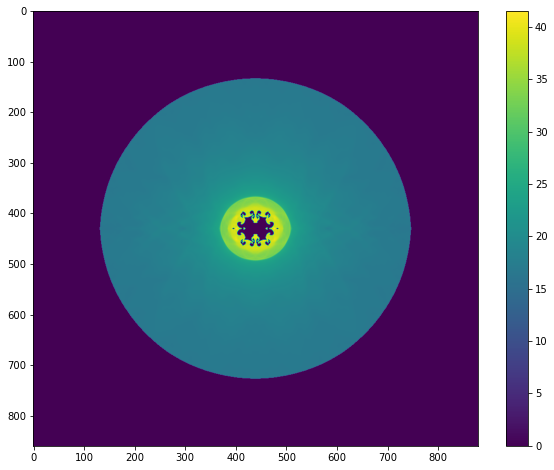

In [24]:
dyn = np.loadtxt('/home/huangz78/hydro/leo1_trada.txt')
heg = 860
wid = 880
dx = 2.558140 * 1e-2 
dy = 2.500000 * 1e-2
dyn = np.reshape(dyn,(heg,wid))
Rx = dx * 320
Ry = dy * 320
R  = min(Rx,Ry)

plt.figure(figsize=(10,8))
plt.imshow(dyn)
plt.colorbar()
plt.show()

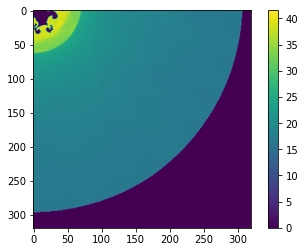

In [25]:
imgslice = dyn[heg//2:heg//2+320,wid//2:wid//2+320]
plt.imshow(imgslice)
plt.colorbar()
plt.show()

In [26]:
integration_over_sphere(imgslice,R=R,Rx=Rx,Ry=Ry)

326.62647290951725

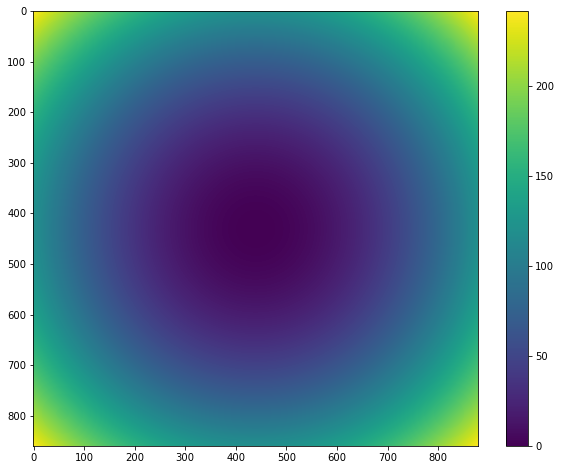

384076.717677827


In [44]:
heg = 860
wid = 880
dx = 2.558140 * 1e-2 
dy = 2.500000 * 1e-2

weights = np.array([[i**2+j**2 for j in (np.arange(0,wid)-wid//2)*dy] for i in (np.arange(0,heg)-heg//2)*dx])
plt.figure(figsize=(10,8))
plt.imshow(weights)
plt.colorbar()
plt.show()

summation = np.sum(np.multiply(weights,dyn))*(dx*dy)*4/3*np.pi
print(summation)

# summation = np.zeros((dep))
# for t in range(dep):
#     summation[t] = np.sum(np.multiply(weights,dyn[0,0,t,:,:]))
# plt.figure()
# plt.scatter(range(dep),summation)
# plt.xlabel('frame number')
# plt.ylabel('weighted summation of pixels')
# plt.show()

Total amount of files: 13798


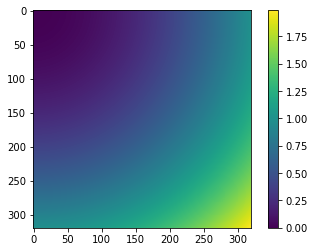

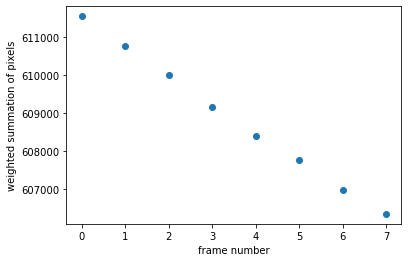

In [13]:
weights = np.array([[i**2+j**2 for i in np.arange(0,img_size)/img_size] for j in np.arange(0,img_size)/img_size])
plt.figure()
plt.imshow(weights)
plt.colorbar()
plt.show()

summation = np.zeros((dep))
for t in range(dep):
    summation[t] = np.sum(np.multiply(weights,dyn[0,0,t,:,:]))
plt.figure()
plt.scatter(range(dep),summation)
plt.xlabel('frame number')
plt.ylabel('weighted summation of pixels')
plt.show()

# track adversial training errors

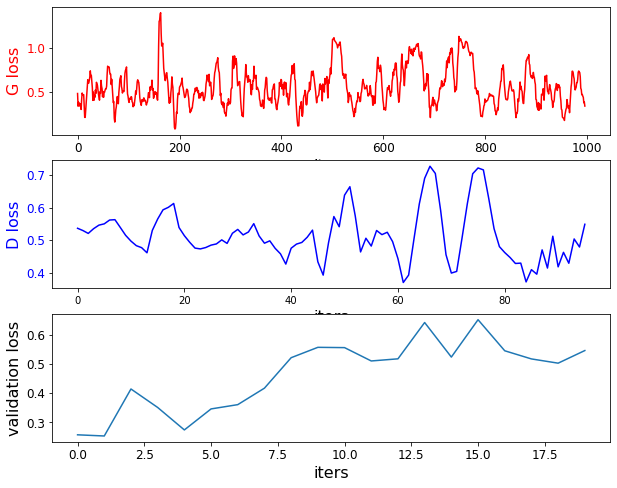

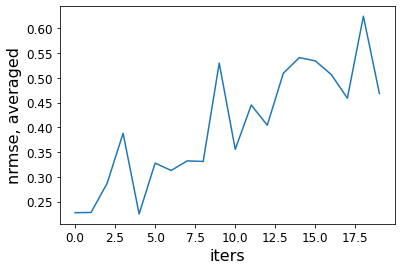

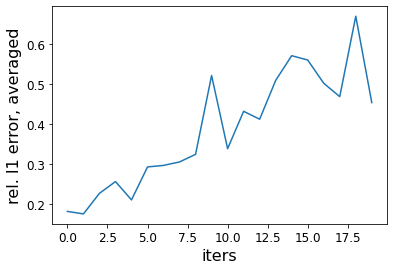

In [9]:
errorRec_path = '/home/huangz78/checkpoints/gan_train_track.npz'
errordata = np.load(errorRec_path)
%matplotlib inline
visualization(errordata['g_loss'],errordata['d_loss'],errordata['val_loss'],\
              errordata['nrmse_val'],errordata['l1_val'],\
              log_loss=False,log_val=False,log_err=False,window=5)

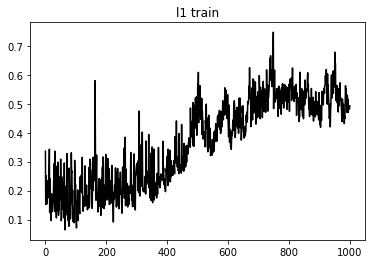

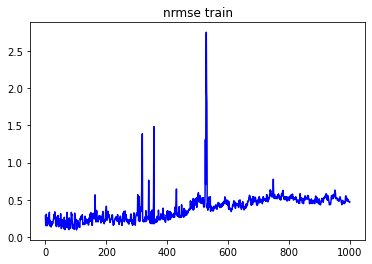

In [6]:
plt.figure(figsize=(6,4))
plt.plot(errordata['l1_train'],'k')
plt.title('l1 train')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(errordata['nrmse_train'],'b')
plt.title('nrmse train')
plt.show()

# check denoised slices

In [2]:
errorRec_path = '/home/huangz78/checkpoints/gnet_warmup_track.npz'
errordata = np.load(errorRec_path)
%matplotlib inline
print(errordata.files)

['g_loss', 'val_loss', 'val_loss_cmp', 'nrmse_train', 'l1_train', 'nrmse_val', 'l1_val', 'nrmse_val_cmp', 'l1_val_cmp']


In [3]:
visualization(errordata,errordata.files,log=False,figsize=(10,35))

TypeError: visualization() got an unexpected keyword argument 'log'

In [33]:
errorRec_path = '/home/huangz78/checkpoints/wgan_train_track.npz'
errordata = np.load(errorRec_path)
print(errordata.files)
%matplotlib inline

['g_loss', 'd_loss', 'Massdiffs', 'nrmse_train', 'l1_train', 'nrmse_val', 'l1_val', 'bce_real', 'bce_fake']


In [34]:
def visualization(data,labels,\
                  log=False,window=0,figsize=(15,25),fontsize=16):
    nums = len(data)
    colors = ['r','b','g','tab:orange','tab:purple','tab:brown','k',\
              'deeppink','darkblue','darkorange','darkslategray','darkseagreen']
    fig,axs = plt.subplots(nums,1,figsize=figsize)
    for ind in range(nums):
        axs[ind].set_xlabel('iters', fontsize=fontsize)
        axs[ind].set_ylabel(labels[ind], color=colors[ind], fontsize=fontsize)
        if window > 0:
            axs[ind].plot(rolling_mean(data[labels[ind]],window), color=colors[ind])
        else:
            axs[ind].plot(data[labels[ind]], color=colors[ind])
        axs[ind].tick_params(axis='x', labelsize='large')
        axs[ind].tick_params(axis='y', labelcolor=colors[ind],labelsize='large')
        if log:
            axs[ind].set_yscale('log')
    plt.show()

In [6]:
errordata['bce_real'][-10:]

array([0.81131333, 0.8153931 , 0.8066121 , 0.78678334, 0.76448476,
       0.7827698 , 0.804922  , 0.8136817 , 0.8148349 , 0.8202771 ],
      dtype=float32)

In [5]:
errordata['bce_fake'][-10:]

array([0.49140373, 0.48709446, 0.49432367, 0.51596624, 0.5255828 ,
       0.5228466 , 0.5276036 , 0.53052807, 0.5308778 , 0.51724356],
      dtype=float32)

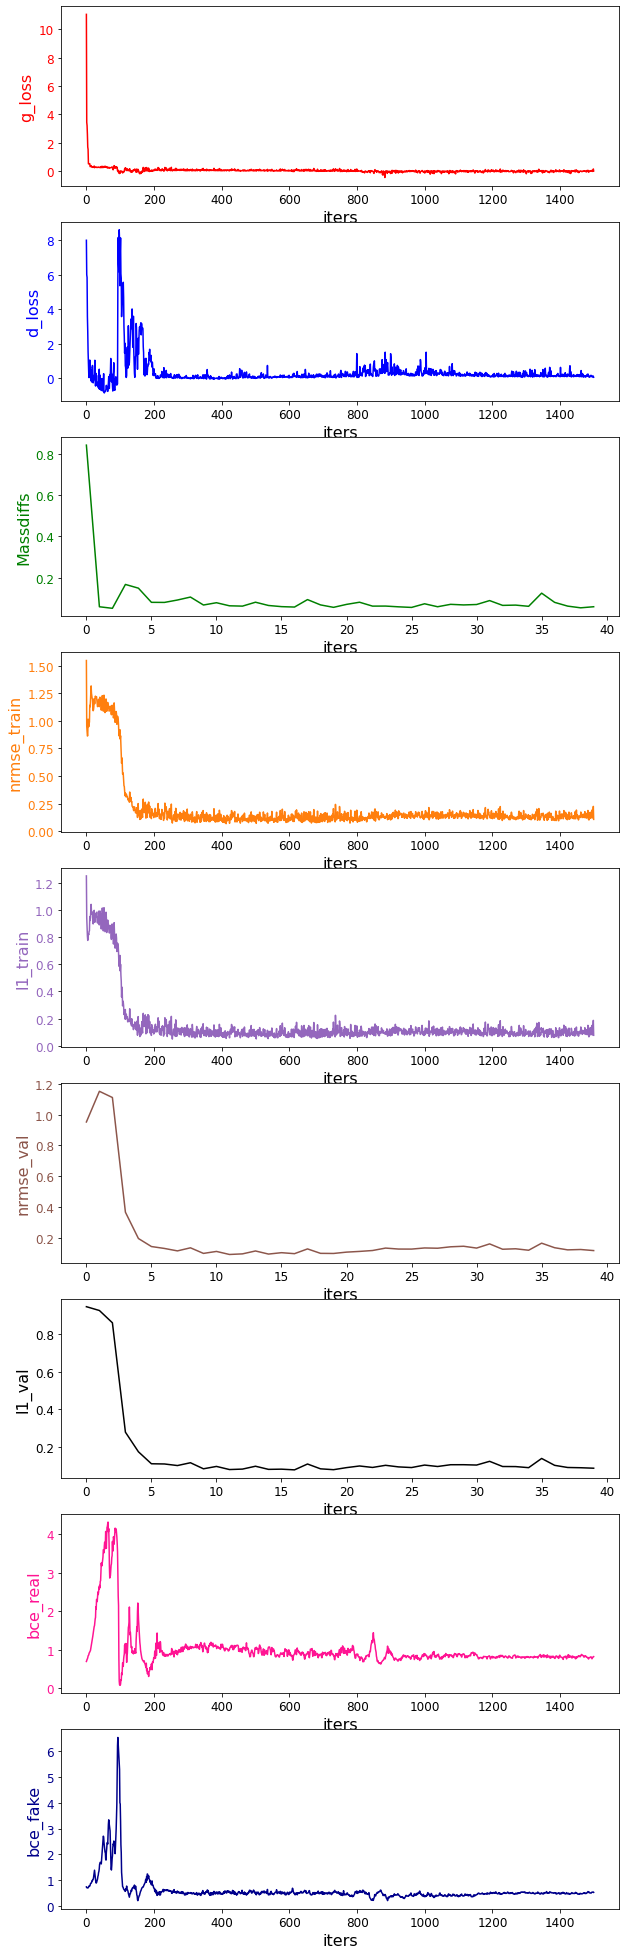

In [35]:
visualization(errordata,errordata.files,log=False,figsize=(10,35))

In [2]:
# load a G net
# gnet = UNet3D(1,1,is_segmentation=False,final_sigmoid=False)
gnet = ResidualUNet3D(1,1,num_levels=4,is_segmentation=False,final_sigmoid=False)
gpath = '/home/huangz78/checkpoints/netG_wg.pt'
# gpath = '/home/huangz78/checkpoints/netG_warmup_masspenned.pt'
checkpoint = torch.load(gpath)
gnet.load_state_dict(checkpoint['model_state_dict'],strict=True)
gnet.eval()
print(f' G net is successfully loaded from {gpath}! ')
gnet_params_nums = sum(p.numel() for p in gnet.parameters() if p.requires_grad) 
print('total amount of parameters in gnet: ', gnet_params_nums)

 G net is successfully loaded from /home/huangz78/checkpoints/netG_wg.pt! 
total amount of parameters in gnet:  35067331


In [3]:
dnet = Discriminator(0,ndf=2,sigmoid_on=False,imgsize=(8,320,320)).to('cpu')
dpath = '/home/huangz78/checkpoints/netD_wg.pt'
checkpoint = torch.load(dpath)
dnet.load_state_dict(checkpoint['model_state_dict'],strict=True)

dnet_params_nums = sum(p.numel() for p in dnet.parameters() if p.requires_grad) 
print('total amount of parameters in dnet: ', dnet_params_nums )# dnet.apply(weights_init)

total amount of parameters in dnet:  8686957


In [4]:
gnet_params_nums/dnet_params_nums

4.03677962259972

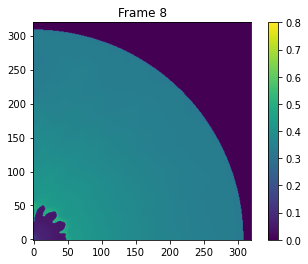

In [5]:
datapath = '/mnt/shared_b/data/hydro_simulations/data/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".nc"):
        ncfiles.append(file)
print('Total amount of files:', len(ncfiles))
img_size = 320
dep = 8
fileexp_ind = 8046

# for fileexp_ind in range(len(ncfiles)):
filename = ncfiles[fileexp_ind]
sim = xr.open_dataarray(datapath+filename)
sim.close()

subgroup = 0
dyn   = torch.zeros((1,1,dep,img_size,img_size))    # load one sample, show it
noise = torch.zeros((1,1,dep,img_size,img_size))    
for t in range(dep):
#     dyn[0,0,t,:,:] = torch.tensor( sim.isel(t=t)[:img_size,:img_size].values )
    dyn[0,0,t,:,:] = torch.tensor( sim.isel(t=t+dep*subgroup)[:img_size,:img_size].values )
# for t in range(dep):
#     dyn[0,0,t,:,:] = resize(sim.isel(t=t)[:img_size,:img_size].values,(256,256),anti_aliasing=True)

normalize_factor   = 50
dyn = dyn.clamp(max=normalize_factor)
dyn[0,0,:,:,:]  = dyn[0,0,:,:,:] / normalize_factor

noise = np.zeros(dyn.shape) # make a noise sample, add it to the ground truth, show it
for t in range(dep): # different noise for each frame when using a 'for' loop
#     noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='linear',scaling=dyn.max().numpy()) 
    noise[0,0,t,:,:] = noise_generate(dyn[0,0,t,:,:],mode='const_rand',scaling=dyn.max().numpy()) 
dyn = torch.tensor(dyn).to(torch.float); noise = torch.tensor(noise).to(torch.float)
%matplotlib inline

# illustrate(dyn,vmin=-np.inf,vmax=np.inf,title='ground truth dynamics')
# illustrate(dyn + noise,vmin=-np.inf,vmax=np.inf,title='noisy dynamics')
# illustrate(torch.divide(noise.abs(),dyn),vmin=0,vmax=.1,title='relative L1 error')

from IPython.display import clear_output
plt.figure()
for i in range(dep):
    plt.imshow(dyn[0,0,i,:,:],origin='lower')
    plt.colorbar()
    plt.clim(0, .8)
#     plt.title('Frame %d' % (i+1))
    plt.title('Frame %d' % (i+1+dep*subgroup))
#     plt.savefig(f'/home/huangz78/checkpoints/frame_{i}.jpg',bbox_inches='tight', transparent=True,
#                pad_inches=.2, dpi=300)
    plt.show()
    clear_output(wait=True)

un-denoised L2 err:  0.25536516308784485
denoised    L2 err:  0.1423158496618271
un-denoised L1 err:  0.28148263692855835
denoised    L1 err:  0.10888399928808212


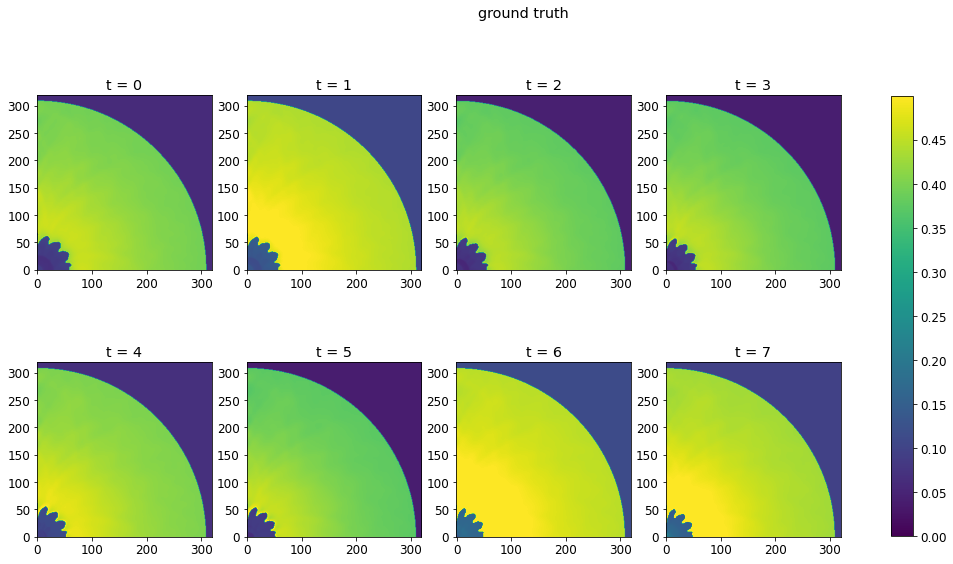

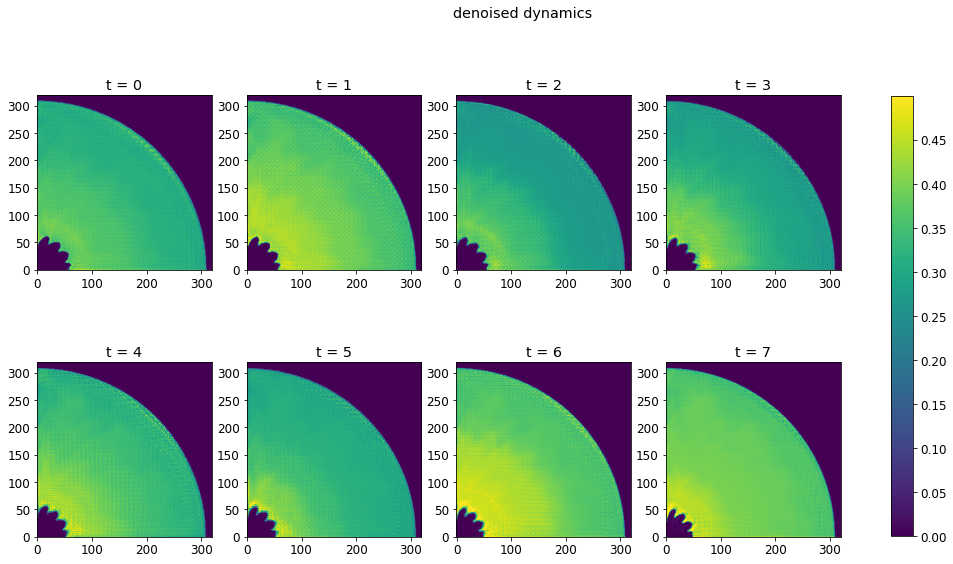

In [7]:
# apply denoiser, show the outcome
noisy_dyn = noise + dyn
denoised_dyn = gnet(noisy_dyn).clamp(min=0).detach()

print('un-denoised L2 err: ',(torch.norm(noisy_dyn - dyn)/torch.norm(dyn)).item())
print('denoised    L2 err: ', (torch.norm(denoised_dyn - dyn)/torch.norm(dyn)).item())
print('un-denoised L1 err: ',(torch.norm(noisy_dyn - dyn,p=1)/torch.norm(dyn,p=1)).item())
print('denoised    L1 err: ', (torch.norm(denoised_dyn - dyn,p=1)/torch.norm(dyn,p=1)).item())
illustrate(noisy_dyn,vmin=0,vmax=0.5,title='ground truth')
illustrate(denoised_dyn,vmin=0,vmax=0.5,title='denoised dynamics')

In [8]:
def postprocessor(denoised_dyn,truemass,lr=5e-2,maxIter=2000,L=100):
    # loss function = ||x - G(noisy_dyn)||_2^2 + L *|| compute_mass(x) - true_mass ||_2^2
    denoised_dyn_cp = copy.copy(denoised_dyn)
    denoised_dyn = Variable(denoised_dyn, requires_grad=True)
    for t in range(maxIter):
        mass_denoised = compute_mass(denoised_dyn)
        mass_denoised.retain_grad()
        # Compute and print loss using operations on Variables.
        loss = torch.norm(denoised_dyn - denoised_dyn_cp,p=2)**2 + L * torch.norm(mass_denoised - truemass)**2
        print(t, loss.data)

        loss.backward()
        denoised_dyn.data -= lr * denoised_dyn.grad.data

        denoised_dyn.grad.data.zero_() # Manually zero the gradients after updating weights
    return denoised_dyn.data

In [9]:
truemass = compute_mass(dyn)
further_denoised_dyn = postprocessor(denoised_dyn,truemass,lr=1e-1)

0 tensor(3.7233)
1 tensor(3.7042)
2 tensor(3.6851)
3 tensor(3.6662)
4 tensor(3.6473)
5 tensor(3.6286)
6 tensor(3.6099)
7 tensor(3.5913)
8 tensor(3.5729)
9 tensor(3.5545)
10 tensor(3.5362)
11 tensor(3.5180)
12 tensor(3.5000)
13 tensor(3.4820)
14 tensor(3.4641)
15 tensor(3.4462)
16 tensor(3.4285)
17 tensor(3.4109)
18 tensor(3.3934)
19 tensor(3.3759)
20 tensor(3.3585)
21 tensor(3.3413)
22 tensor(3.3241)
23 tensor(3.3070)
24 tensor(3.2900)
25 tensor(3.2731)
26 tensor(3.2563)
27 tensor(3.2395)
28 tensor(3.2229)
29 tensor(3.2063)
30 tensor(3.1898)
31 tensor(3.1734)
32 tensor(3.1571)
33 tensor(3.1408)
34 tensor(3.1247)
35 tensor(3.1086)
36 tensor(3.0926)
37 tensor(3.0767)
38 tensor(3.0609)
39 tensor(3.0452)
40 tensor(3.0295)
41 tensor(3.0140)
42 tensor(2.9985)
43 tensor(2.9830)
44 tensor(2.9677)
45 tensor(2.9524)
46 tensor(2.9373)
47 tensor(2.9222)
48 tensor(2.9071)
49 tensor(2.8922)
50 tensor(2.8773)
51 tensor(2.8625)
52 tensor(2.8478)
53 tensor(2.8332)
54 tensor(2.8186)
55 tensor(2.8041)
56

447 tensor(0.3717)
448 tensor(0.3698)
449 tensor(0.3679)
450 tensor(0.3660)
451 tensor(0.3641)
452 tensor(0.3622)
453 tensor(0.3604)
454 tensor(0.3585)
455 tensor(0.3567)
456 tensor(0.3548)
457 tensor(0.3530)
458 tensor(0.3512)
459 tensor(0.3494)
460 tensor(0.3476)
461 tensor(0.3458)
462 tensor(0.3440)
463 tensor(0.3423)
464 tensor(0.3405)
465 tensor(0.3387)
466 tensor(0.3370)
467 tensor(0.3353)
468 tensor(0.3335)
469 tensor(0.3318)
470 tensor(0.3301)
471 tensor(0.3284)
472 tensor(0.3267)
473 tensor(0.3251)
474 tensor(0.3234)
475 tensor(0.3217)
476 tensor(0.3201)
477 tensor(0.3184)
478 tensor(0.3168)
479 tensor(0.3152)
480 tensor(0.3135)
481 tensor(0.3119)
482 tensor(0.3103)
483 tensor(0.3087)
484 tensor(0.3071)
485 tensor(0.3056)
486 tensor(0.3040)
487 tensor(0.3024)
488 tensor(0.3009)
489 tensor(0.2993)
490 tensor(0.2978)
491 tensor(0.2963)
492 tensor(0.2947)
493 tensor(0.2932)
494 tensor(0.2917)
495 tensor(0.2902)
496 tensor(0.2887)
497 tensor(0.2872)
498 tensor(0.2858)
499 tensor(0

908 tensor(0.0345)
909 tensor(0.0343)
910 tensor(0.0342)
911 tensor(0.0340)
912 tensor(0.0338)
913 tensor(0.0336)
914 tensor(0.0335)
915 tensor(0.0333)
916 tensor(0.0331)
917 tensor(0.0330)
918 tensor(0.0328)
919 tensor(0.0326)
920 tensor(0.0324)
921 tensor(0.0323)
922 tensor(0.0321)
923 tensor(0.0320)
924 tensor(0.0318)
925 tensor(0.0316)
926 tensor(0.0315)
927 tensor(0.0313)
928 tensor(0.0311)
929 tensor(0.0310)
930 tensor(0.0308)
931 tensor(0.0307)
932 tensor(0.0305)
933 tensor(0.0303)
934 tensor(0.0302)
935 tensor(0.0300)
936 tensor(0.0299)
937 tensor(0.0297)
938 tensor(0.0296)
939 tensor(0.0294)
940 tensor(0.0293)
941 tensor(0.0291)
942 tensor(0.0290)
943 tensor(0.0288)
944 tensor(0.0287)
945 tensor(0.0285)
946 tensor(0.0284)
947 tensor(0.0282)
948 tensor(0.0281)
949 tensor(0.0279)
950 tensor(0.0278)
951 tensor(0.0277)
952 tensor(0.0275)
953 tensor(0.0274)
954 tensor(0.0272)
955 tensor(0.0271)
956 tensor(0.0270)
957 tensor(0.0268)
958 tensor(0.0267)
959 tensor(0.0265)
960 tensor(0

1371 tensor(0.0032)
1372 tensor(0.0032)
1373 tensor(0.0031)
1374 tensor(0.0031)
1375 tensor(0.0031)
1376 tensor(0.0031)
1377 tensor(0.0031)
1378 tensor(0.0031)
1379 tensor(0.0030)
1380 tensor(0.0030)
1381 tensor(0.0030)
1382 tensor(0.0030)
1383 tensor(0.0030)
1384 tensor(0.0030)
1385 tensor(0.0030)
1386 tensor(0.0029)
1387 tensor(0.0029)
1388 tensor(0.0029)
1389 tensor(0.0029)
1390 tensor(0.0029)
1391 tensor(0.0029)
1392 tensor(0.0028)
1393 tensor(0.0028)
1394 tensor(0.0028)
1395 tensor(0.0028)
1396 tensor(0.0028)
1397 tensor(0.0028)
1398 tensor(0.0028)
1399 tensor(0.0027)
1400 tensor(0.0027)
1401 tensor(0.0027)
1402 tensor(0.0027)
1403 tensor(0.0027)
1404 tensor(0.0027)
1405 tensor(0.0027)
1406 tensor(0.0026)
1407 tensor(0.0026)
1408 tensor(0.0026)
1409 tensor(0.0026)
1410 tensor(0.0026)
1411 tensor(0.0026)
1412 tensor(0.0026)
1413 tensor(0.0026)
1414 tensor(0.0025)
1415 tensor(0.0025)
1416 tensor(0.0025)
1417 tensor(0.0025)
1418 tensor(0.0025)
1419 tensor(0.0025)
1420 tensor(0.0025)


1838 tensor(0.0003)
1839 tensor(0.0003)
1840 tensor(0.0003)
1841 tensor(0.0003)
1842 tensor(0.0003)
1843 tensor(0.0003)
1844 tensor(0.0003)
1845 tensor(0.0003)
1846 tensor(0.0003)
1847 tensor(0.0003)
1848 tensor(0.0003)
1849 tensor(0.0003)
1850 tensor(0.0003)
1851 tensor(0.0003)
1852 tensor(0.0003)
1853 tensor(0.0003)
1854 tensor(0.0003)
1855 tensor(0.0003)
1856 tensor(0.0003)
1857 tensor(0.0003)
1858 tensor(0.0003)
1859 tensor(0.0003)
1860 tensor(0.0003)
1861 tensor(0.0003)
1862 tensor(0.0003)
1863 tensor(0.0003)
1864 tensor(0.0002)
1865 tensor(0.0002)
1866 tensor(0.0002)
1867 tensor(0.0002)
1868 tensor(0.0002)
1869 tensor(0.0002)
1870 tensor(0.0002)
1871 tensor(0.0002)
1872 tensor(0.0002)
1873 tensor(0.0002)
1874 tensor(0.0002)
1875 tensor(0.0002)
1876 tensor(0.0002)
1877 tensor(0.0002)
1878 tensor(0.0002)
1879 tensor(0.0002)
1880 tensor(0.0002)
1881 tensor(0.0002)
1882 tensor(0.0002)
1883 tensor(0.0002)
1884 tensor(0.0002)
1885 tensor(0.0002)
1886 tensor(0.0002)
1887 tensor(0.0002)


un-denoised L2 err:  0.25536516308784485
further denoised L2 err:  0.12808728218078613
un-denoised L1 err:  0.28148263692855835
further denoised L1 err:  0.10759538412094116


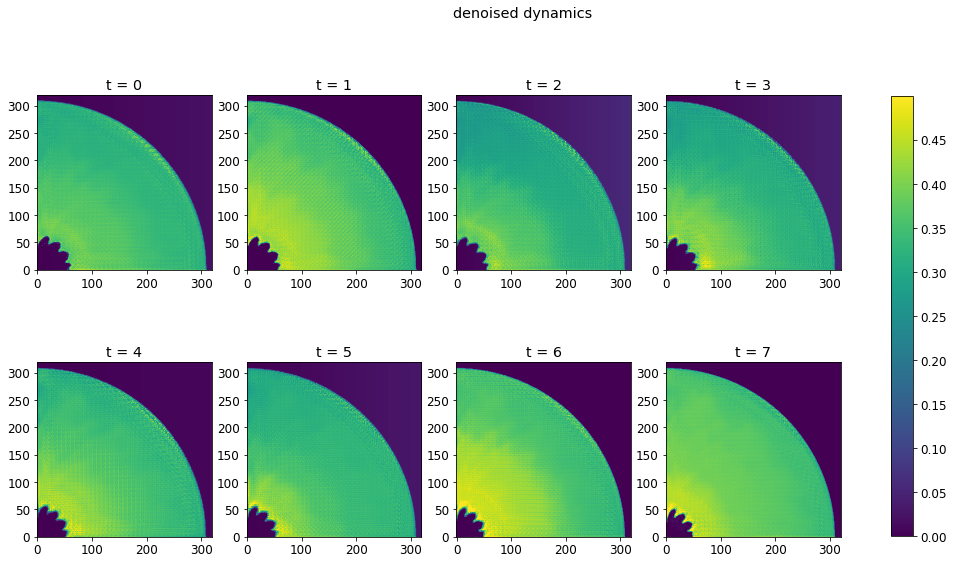

In [10]:
print('un-denoised L2 err: ',(torch.norm(noisy_dyn - dyn)/torch.norm(dyn)).item())
print('further denoised L2 err: ', (torch.norm(further_denoised_dyn - dyn)/torch.norm(dyn)).item())
print('un-denoised L1 err: ',(torch.norm(noisy_dyn - dyn,p=1)/torch.norm(dyn,p=1)).item())
print('further denoised L1 err: ', (torch.norm(further_denoised_dyn - dyn,p=1)/torch.norm(dyn,p=1)).item())
illustrate(further_denoised_dyn,vmin=0,vmax=.5,title='denoised dynamics')

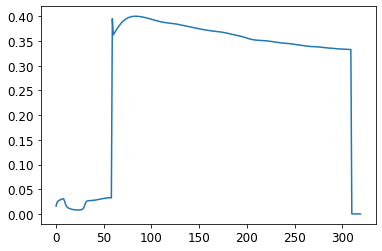

In [14]:
plt.plot(dyn[0,0,0,0,:])

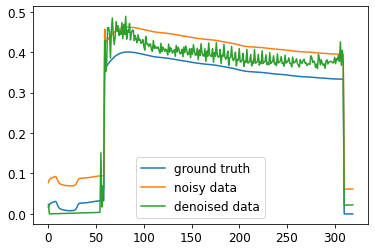

In [11]:
# plot line profile
plt.figure()
plt.plot(dyn[0,0,0,0,:], label='ground truth')
plt.plot(noisy_dyn[0,0,0,0,:], label='noisy data')
plt.plot(denoised_dyn[0,0,0,0,:], label='denoised data')
# plt.plot(further_denoised_dyn[0,0,0,0,:], label='further denoised data')
plt.legend(loc='best')
plt.show()

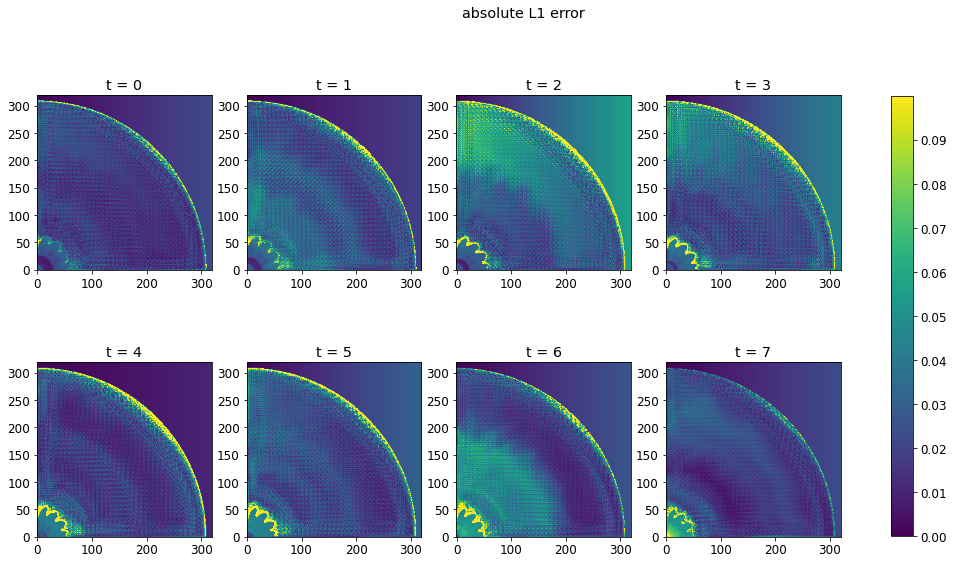

In [12]:
# illustrate(torch.divide((further_denoised_dyn - dyn+1e-10).abs(),dyn+1e-10),vmin=0,vmax=1,title='relative L1 error')
illustrate((further_denoised_dyn - dyn).abs(),vmin=0,vmax=.1,title='absolute L1 error')

In [25]:
import datetime
import imageio
def create_gif(filenames, duration):
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
    output_file = '/home/huangz78/checkpoints/Gif-%s.gif' % datetime.datetime.now().strftime('%Y-%M-%d-%H-%M-%S')
    imageio.mimsave(output_file, images, duration=duration)

In [31]:
filenames=[f'/home/huangz78/checkpoints/frame_{i}.jpg' for i in range(41)]

In [32]:
create_gif(filenames, .4)